In [1]:
import numpy as np
import matplotlib
matplotlib.use('TkAgg')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import matplotlib.axis as ax
import pandas as pd
import geopandas as gpd
#import cartopy.crs as ccrs
#import cartopy.feature as cfeature
from obspy.core import UTCDateTime
from shapely.geometry.polygon import Polygon
from shapely.geometry import Point
import os
from datetime import timedelta, date
from obspy.clients.fdsn import Client
import pygmt
from scipy.ndimage import uniform_filter1d
import statsmodels.api as sm
from datetime import datetime, timedelta

# Read in hypoDD data

In [2]:
cwd = os.getcwd()
path = cwd + "/DD_NC.txt"
hypodd = pd.read_csv(path, sep='\s+')
#print(hypoDD)
print(len(hypodd))

513474


# Define Params

In [3]:
lat = hypodd["LAT"]
lon = hypodd["LON"]
mag = hypodd["MAG"]
NC_bounds = [-121.5380,-120.4327,35.8997,36.8455]

In [4]:
#select data to plot on map
sel_lat = np.logical_and(hypodd["LAT"] >= NC_bounds[2], hypodd["LAT"] <= NC_bounds[3])
sel_lon = np.logical_and(hypodd["LON"] >= NC_bounds[0], hypodd["LON"] <= NC_bounds[1])
data_EQ = hypodd[sel_lat][sel_lon]
data_EQ = data_EQ.reset_index()


C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1567303119.py:4: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  data_EQ = hypodd[sel_lat][sel_lon]


In [5]:
#UTCDateTime
t = np.zeros(len(data_EQ))
for i in np.linspace(0,len(data_EQ)-1,len(data_EQ)).astype(int):
    t[i]=UTCDateTime(data_EQ["YEAR"][i],data_EQ["MONTH"][i],data_EQ["DAY"][i],data_EQ["HOUR"][i],data_EQ["MINUTE"][i],data_EQ["SECOND"][i])

# Sequence/Event Data

In [6]:
repeaters = pd.read_csv(cwd+"/DD_Repeat.txt", sep='\s+', header = 1)
print(len(repeaters))

seq = repeaters[repeaters["YR"] == "#"]
seq = seq.drop(columns=["DMAGE","CCm","evID"])
seq = seq.rename(columns={"YR":"#","MO":"NEV","DY":"LATm","HR":"LONm","MN":"DEPm","SC":"DMAGm","DAYS":"DMAGs","LAT":"RCm",
                    "LON":"RCs","DEP":"RCcv","EX":"RCm1","EY":"RCs1","EZ":"RCcv1","MAG":"CCm","DMAG":"seqID"})
seq = seq.reset_index()
#print(seq)
print(len(seq))

repeaters = repeaters[repeaters["YR"] != "#"]
#print(repeaters)
print(len(repeaters))



35387
7713
27674


# Add SeqID column to Repeaters

In [7]:
seq_ID = []
for i in range(len(seq)):
    ID = np.full(seq["NEV"][i], seq["seqID"][i])
    for j in range(len(ID)):
        seq_ID.append(ID[j])
print(len(seq_ID))

repeaters["seqID"] = seq_ID
print(repeaters)

27674
         YR  MO    DY    HR    MN     SC    DAYS       LAT        LON    DEP  \
1      1984   4  30.0  16.0  10.0  25.00   121.0  37.25691 -121.63891  6.771   
2      1984   5   5.0  22.0  24.0  29.26   126.0  37.25691 -121.63892  6.769   
3      1984   5  15.0  22.0  12.0   5.89   136.0  37.25695 -121.63893  6.769   
4      1984   5  29.0   8.0  59.0  52.44   150.0  37.25691 -121.63889  6.766   
5      1984   7  11.0   4.0  52.0   8.48   193.0  37.25696 -121.63892  6.764   
...     ...  ..   ...   ...   ...    ...     ...       ...        ...    ...   
35380  1986   6   1.0   6.0  49.0  34.67   883.0  36.62801 -121.23505  5.188   
35382  1986   7  19.0  21.0  54.0  57.53   931.0  37.63309 -118.91653  2.885   
35383  1997  12   6.0   9.0  20.0  26.84  5089.0  37.63291 -118.91637  2.825   
35385  1986   7  20.0  16.0  13.0  12.46   932.0  37.54657 -118.46472  7.183   
35386  1986   7  20.0  18.0  55.0  42.38   932.0  37.54673 -118.46477  7.257   

         EX    EY    EZ   MAG  DM

# Select Data

In [8]:
sel_lat2 = np.logical_and(repeaters["LAT"] >= NC_bounds[2], repeaters["LAT"] <= NC_bounds[3])
sel_lon2 = np.logical_and(repeaters["LON"] >= NC_bounds[0], repeaters["LON"] <= NC_bounds[1])
rep_NC = repeaters[sel_lat2][sel_lon2]
rep_NC = rep_NC.reset_index()
#print(rep_NC)

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2406568030.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  rep_NC = repeaters[sel_lat2][sel_lon2]


In [9]:
rep_NC["YR"] = rep_NC["YR"].astype(int)
rep_NC["MO"] = rep_NC["MO"].astype(int)
rep_NC["LAT"] = rep_NC["LAT"].astype(float)
rep_NC["LON"] = rep_NC["LON"].astype(float)

# Plot Map Data

In [10]:
bin_start = UTCDateTime(1984,1,1)
bin_start = float(bin_start)
bin_end = UTCDateTime(2015,1,1)
bin_end = float(bin_end)
rep_bin = np.linspace(bin_start, bin_end, 360)
#plt.figure(7)
#plt.hist(t_rep, bins = rep_bin)
#plt.show()

# Select Sequence Data

In [11]:
sel_seqlat = np.logical_and(seq["LATm"] >= NC_bounds[2], seq["LATm"] <= NC_bounds[3])
sel_seqlon = np.logical_and(seq["LONm"] >= NC_bounds[0], seq["LONm"] <= NC_bounds[1])
seq = seq[sel_seqlat][sel_seqlon]
seq = seq.reset_index()
seq = seq.rename(columns={"level_0":"level_1"})
#print(seq)


C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\3482894147.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq = seq[sel_seqlat][sel_seqlon]


In [12]:
sel_burst = np.logical_and(pd.isnull(seq["RCcv"]), seq["RCm"] <=100)
sel_burst = np.logical_or(seq["RCcv"] >=1.2, sel_burst)
sel_burst = np.logical_and(sel_burst, pd.isnull(seq["RCcv1"]))

sel_char = np.logical_not(sel_burst)

char = seq[sel_char] # selects characteristic/periodic repeating families, for comparison to main dataset
char = char.reset_index()
char = char.rename(columns={"level_0":"level_2"})

seq = seq[sel_burst] # selects cluster-like/nonperidic repeating families, main dataset
seq = seq.reset_index()
seq = seq.rename(columns={"level_0":"level_2"})
print(seq)

     level_2  level_1  index  #  NEV     LATm      LONm   DEPm  DMAGm  DMAGs  \
0         55      112    848  #    3  36.6021 -121.2077  5.807   1.07   0.16   
1         88      165   1114  #    3  36.6866 -121.3181  4.187   0.92   0.18   
2         93      173   1150  #    3  36.6894 -121.3223  5.030   0.97   0.17   
3         95      178   1170  #    3  36.5769 -121.1530  3.293   0.95   0.11   
4        112      239   1415  #    2  36.7122 -121.2300  8.485   0.76   0.11   
..       ...      ...    ... ..  ...      ...       ...    ...    ...    ...   
385     2420     7635  35145  #    3  36.7758 -121.4976  7.453   2.72   0.16   
386     2421     7636  35149  #    2  36.8436 -121.3019  6.610   3.33   0.13   
387     2422     7654  35204  #    2  36.7450 -121.3397  8.095   3.04   0.24   
388     2423     7658  35216  #    2  36.5559 -121.1166  4.669   3.13   0.08   
389     2427     7710  35378  #    2  36.6273 -121.2344  5.139   3.54   0.01   

        RCm     RCs  RCcv   RCm1  RCs1 

# Plot Sequences on Map

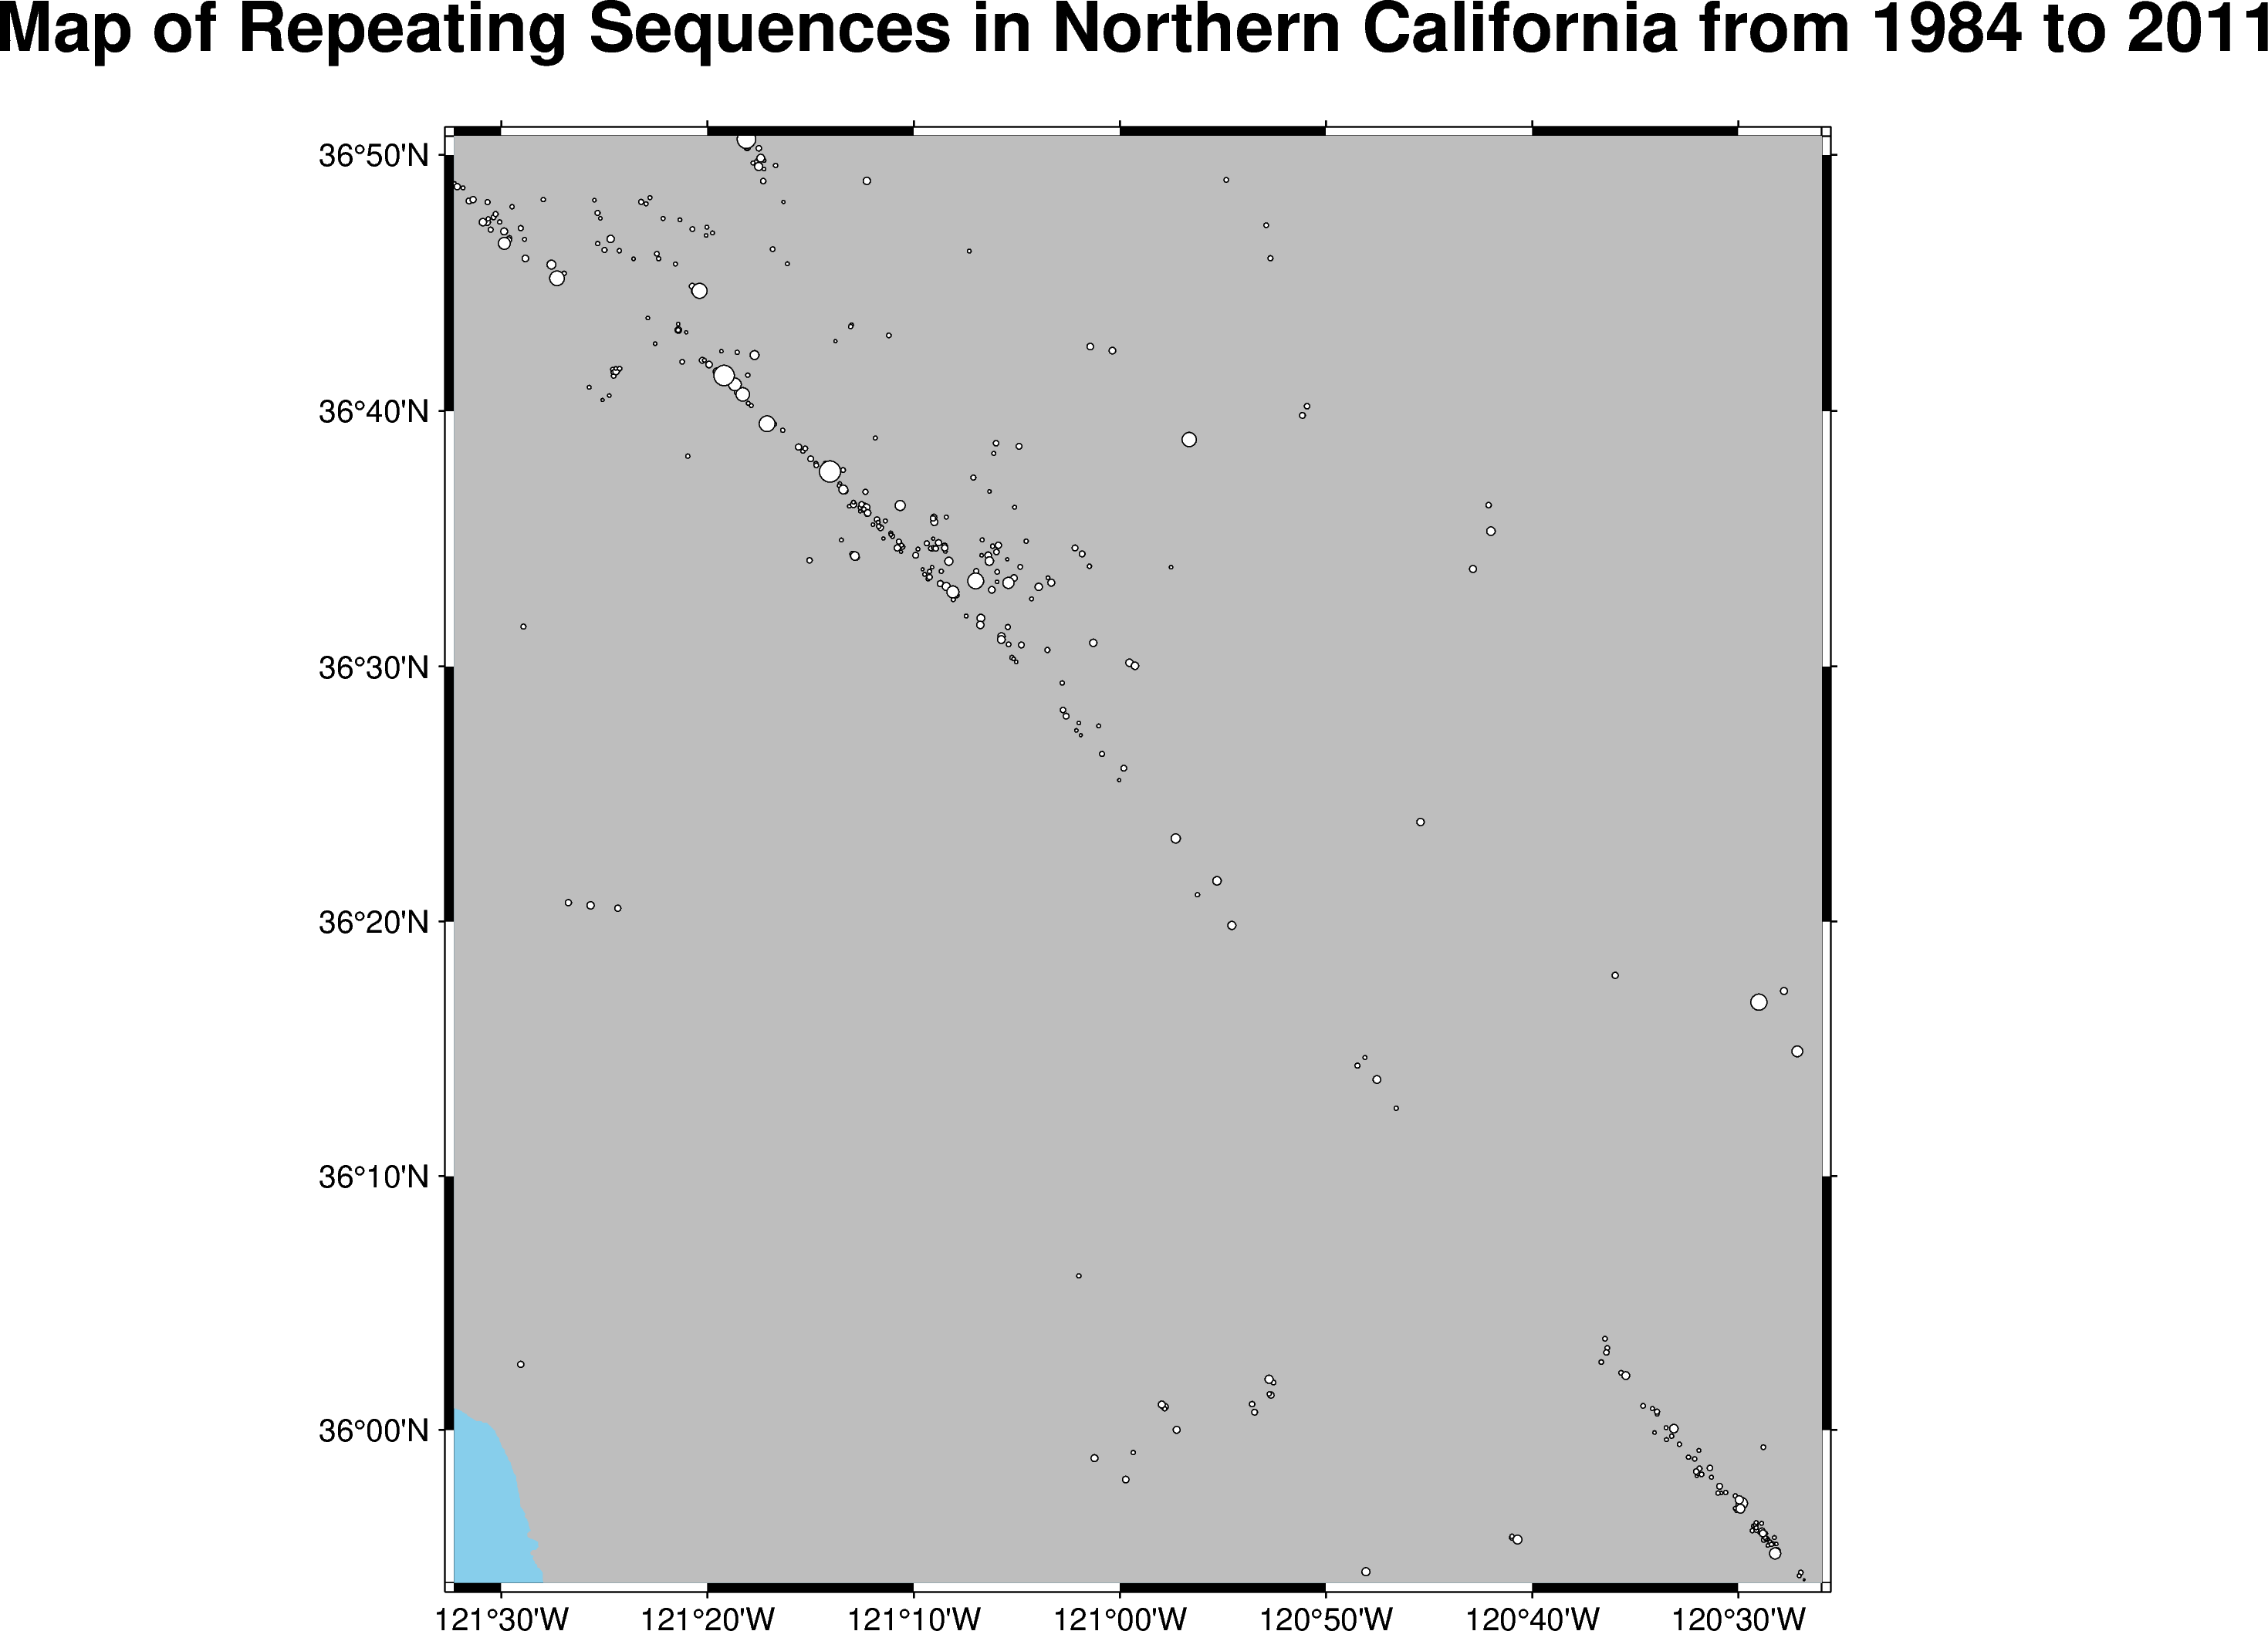

In [13]:
fig = pygmt.Figure()
fig.basemap(region=NC_bounds, projection="M15c", frame=["a", "+tMap of Repeating Sequences in Northern California from 1984 to 2011"])
fig.coast(land="gray", water="skyblue")
#plot sequences
fig.plot(x=seq["LONm"], y=seq["LATm"], size=0.02 * (2**seq["DMAGm"]),style="cc", color="white", pen="black")
fig.show()


# Subsample Sequence Data

In [14]:
s_win = [-121.5380,-121.42747,36.75092,36.8455]
s_lon = [[s_win[0],s_win[0],s_win[1],s_win[1],s_win[0]]]
s_lat = [[s_win[3],s_win[2],s_win[2],s_win[3],s_win[3]]]

CL_bounds = [-121.244,-121.130,36.54,36.65]
CL_lon = [CL_bounds[0],CL_bounds[0],CL_bounds[1],CL_bounds[1],CL_bounds[0]]
CL_lat = [CL_bounds[3],CL_bounds[2],CL_bounds[2],CL_bounds[3],CL_bounds[3]]

repbin_seq = []
for i in np.arange(1984, 2014):
    for j in np.arange(0,4):
        b = mdates.datestr2num("{}/{}/01".format(i,1+3*j))
        repbin_seq.append(b)
for i in range(20):
    s_win = s_win = [s_win[0]+0.055265,s_win[1]+0.055265,s_win[2]-0.04729,s_win[3]-0.04729]
    s_lon.append([s_win[0],s_win[0],s_win[1],s_win[1],s_win[0]])
    s_lat.append([s_win[3],s_win[2],s_win[2],s_win[3],s_win[3]])

C:\Users\awhip\Anaconda3\envs\ObsPy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


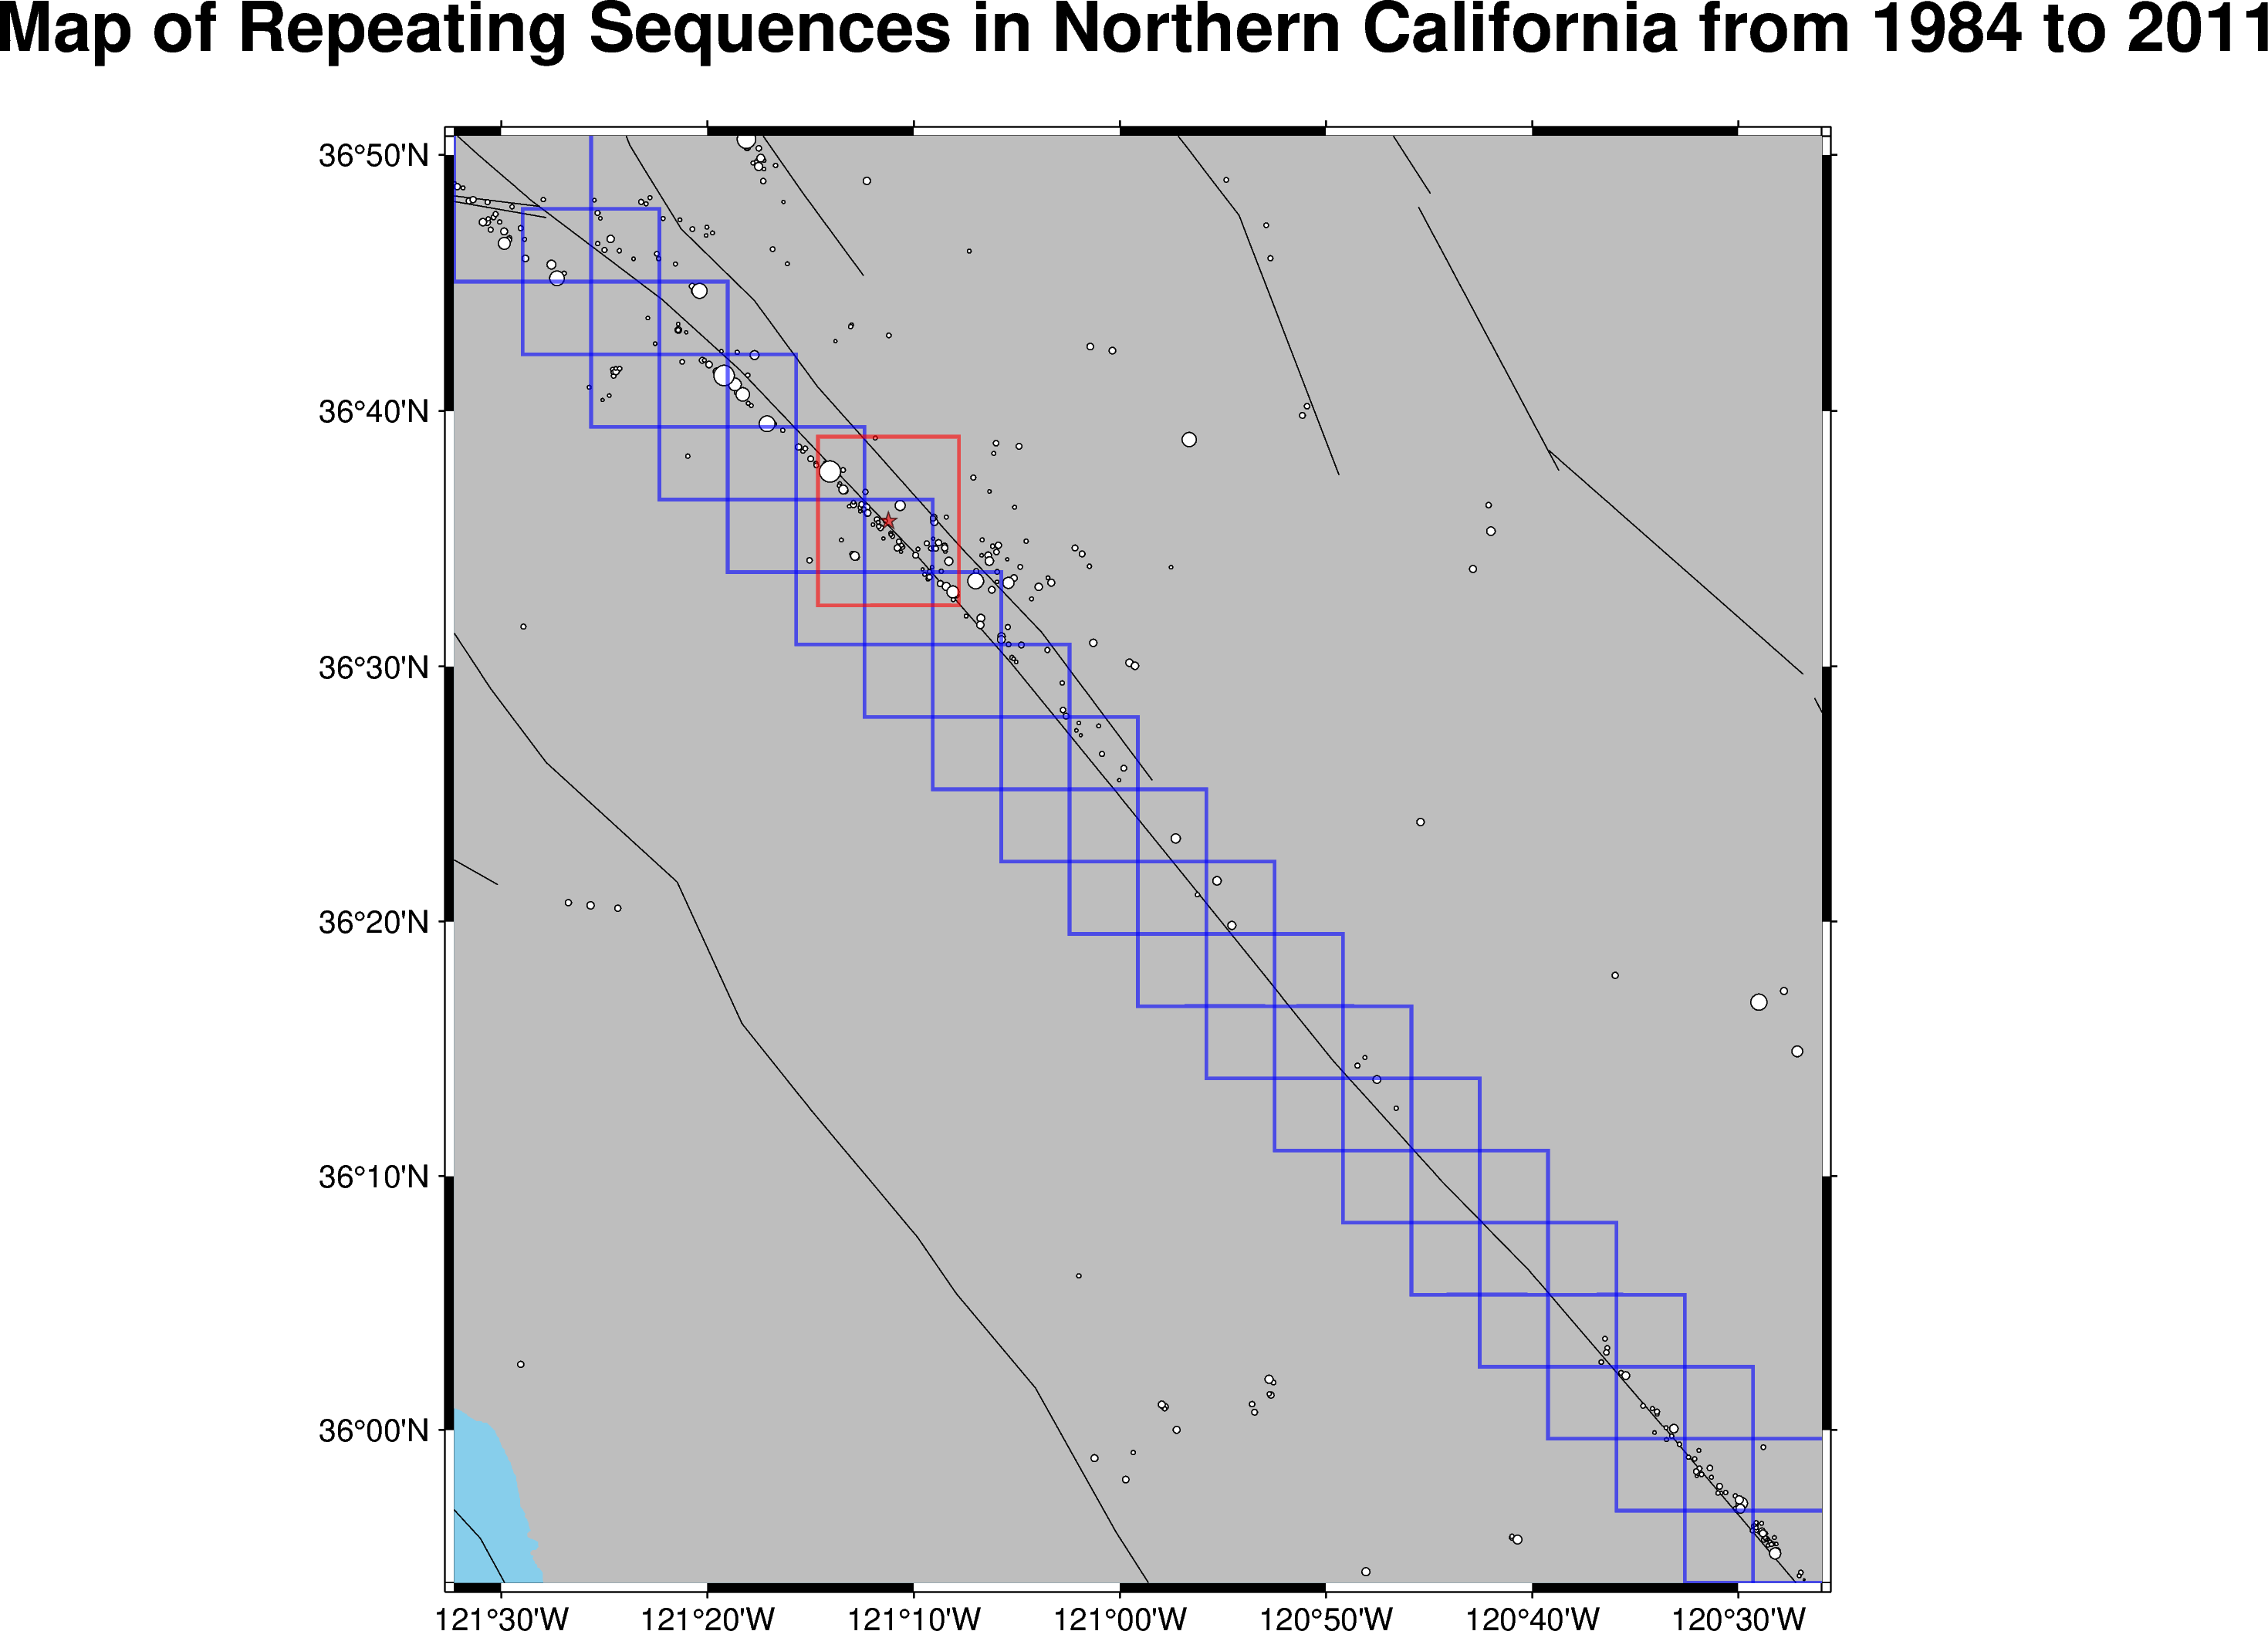

In [15]:
file_map = cwd+'/figures/boxmap.png'
# faults
faults = gpd.read_file(cwd+"/faults/gem_active_faults.shp")
#plot
fig = pygmt.Figure()
fig.basemap(region=NC_bounds, projection="M15c", frame=["a", "+tMap of Repeating Sequences in Northern California from 1984 to 2011"])
fig.coast(land="gray", water="skyblue")
#faults
fig.plot(data=faults)
#plot sequences
fig.plot(x=seq["LONm"], y=seq["LATm"], size=0.02 * (2**seq["DMAGm"]),style="cc", color="white", pen="black")
for i in range(20):
    fig.plot(x=s_lon[i],y=s_lat[i], pen = "1p,blue",transparency=40)
fig.plot(x=CL_lon,y=CL_lat, pen = "1p,red", transparency=40)
fig.plot(x=-121.1870,y=36.5950, style="a0.2c", color="red",pen ="black", transparency=40)
fig.savefig(file_map)
fig.show()

In [16]:
s_win = [-121.5380,-121.42747,36.75092,36.8455]
for i in range(20):
    selat = np.logical_and(seq["LATm"] >= s_win[2], seq["LATm"] <= s_win[3])
    selon = np.logical_and(seq["LONm"] >= s_win[0], seq["LONm"] <= s_win[1])
    seq_win = seq[selat][selon]
    seq_win = seq_win.reset_index()
    print('(%.5f,%.5f,%.5f,%.5f)'%(s_win[0], s_win[1], s_win[2], s_win[3]))
    print("# events: ", len(seq_win))
    print("sum = ", sum(seq_win["NEV"]))
    for j in range(len(seq_win)):
        seq_ev = rep_NC[rep_NC["seqID"]==seq_win["seqID"][j]]
        if j == 0:
            seq_eq = seq_ev
        else:
            seq_eq = seq_eq.append(seq_ev)
    seq_eq = seq_eq.reset_index()
    t_win = np.zeros(len(seq_eq))
    for k in np.linspace(0,len(seq_eq)-1,len(seq_eq)).astype(int):
        t_win[k]=mdates.date2num(UTCDateTime(int(seq_eq["YR"][k]),int(seq_eq["MO"][k]),int(seq_eq["DY"][k]),int(seq_eq["HR"][k]),int(seq_eq["MN"][k]),float(seq_eq["SC"][k])))
    fig, ax = plt.subplots(1, figsize = (12,12))
    plt.cla()
    n, bins, patches = plt.hist(t_win, bins = repbin_seq)
    ax.set(title='Number Of Events vs. Time in (%.5f,%.5f,%.5f,%.5f)'%(s_win[0], s_win[1], s_win[2], s_win[3]))
    ax.xaxis.set_major_locator(mdates.YearLocator())
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
    plt.xlim(mdates.datestr2num(['1984/01/01','2013/12/31']))
    file_map = cwd+'/figures/seqhist_%.1i'%(i)
    plt.savefig(file_map, dpi=150)
        
    plt.pause(0.5)
    plt.clf()
    s_win = [s_win[0]+0.055265,s_win[1]+0.055265,s_win[2]-0.04729,s_win[3]-0.04729]

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq_win = seq[selat][selon]
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and 

(-121.53800,-121.42747,36.75092,36.84550)
# events:  26
sum =  68


C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:

(-121.48273,-121.37220,36.70363,36.79821)
# events:  17
sum =  39


C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq_win = seq[selat][selon]
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and 

(-121.42747,-121.31694,36.65634,36.75092)
# events:  37
sum =  88


C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:

(-121.37220,-121.26167,36.60905,36.70363)
# events:  29
sum =  79


C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:

(-121.31694,-121.20641,36.56176,36.65634)
# events:  30
sum =  78


C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:

(-121.26167,-121.15114,36.51447,36.60905)
# events:  48
sum =  125


C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:

(-121.20641,-121.09588,36.46718,36.56176)
# events:  18
sum =  42


C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq_win = seq[selat][selon]
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and 

(-121.15114,-121.04061,36.41989,36.51447)
# events:  8
sum =  20


C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq_win = seq[selat][selon]
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and 

(-121.09588,-120.98535,36.37260,36.46718)
# events:  7
sum =  21


C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq_win = seq[selat][selon]
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)


(-121.04061,-120.93008,36.32531,36.41989)
# events:  2
sum =  5


C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq_win = seq[selat][selon]
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  seq_eq = seq_eq.append(seq_ev)


(-120.98535,-120.87482,36.27802,36.37260)
# events:  3
sum =  7


C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1936820704.py:5: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq_win = seq[selat][selon]


(-120.93008,-120.81955,36.23073,36.32531)
# events:  0
sum =  0


ValueError: cannot insert level_0, already exists

# Select Area around Calaveras Fault

In [17]:
sel_CLat = np.logical_and(seq["LATm"] >= CL_bounds[2], seq["LATm"] <= CL_bounds[3])
sel_CLon = np.logical_and(seq["LONm"] >= CL_bounds[0], seq["LONm"] <= CL_bounds[1])
seq_CL = seq[sel_CLat][sel_CLon]
seq_CL = seq_CL.reset_index()

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1760350268.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  seq_CL = seq[sel_CLat][sel_CLon]


In [18]:
for i in range(len(seq_CL)):
    eq_CL = rep_NC[rep_NC["seqID"]==seq_CL["seqID"][i]]
    if i == 0:
        rep_CL = eq_CL
    else:
        rep_CL = rep_CL.append(eq_CL)
rep_CL = rep_CL.reset_index()
t_win = np.zeros(len(rep_CL))

for i in np.linspace(0,len(rep_CL)-1,len(rep_CL)).astype(int):
    t_win[i]=mdates.date2num(UTCDateTime(int(rep_CL["YR"][i]),int(rep_CL["MO"][i]),int(rep_CL["DY"][i]),int(rep_CL["HR"][i]),int(rep_CL["MN"][i]),float(rep_CL["SC"][i])))
fig, ax = plt.subplots(1, figsize = (12,12))
n, bins, patches = plt.hist(t_win, bins = repbin_seq)
ax.set(title='Number Of Burst-Like Repeating Events over Time in (%.5f,%.5f,%.5f,%.5f)'%(CL_bounds[0], CL_bounds[1], CL_bounds[2], CL_bounds[3]))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['1984/01/01','2013/12/31']))
file_map = cwd+'/figures/seqCL.png'
plt.savefig(file_map, dpi=150)
plt.show()

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1331008642.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_CL = rep_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1331008642.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_CL = rep_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1331008642.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_CL = rep_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1331008642.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_CL = rep_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1331008642.py:6: Futur

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1331008642.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_CL = rep_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1331008642.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_CL = rep_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1331008642.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_CL = rep_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1331008642.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  rep_CL = rep_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\1331008642.py:6: Futur

In [19]:
sel_CLat = np.logical_and(char["LATm"] >= CL_bounds[2], char["LATm"] <= CL_bounds[3])
sel_CLon = np.logical_and(char["LONm"] >= CL_bounds[0], char["LONm"] <= CL_bounds[1])
char_CL = char[sel_CLat][sel_CLon]
char_CL = char_CL.reset_index()

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\869261412.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  char_CL = char[sel_CLat][sel_CLon]


In [20]:
for i in range(len(char_CL)):
    eq_CL = rep_NC[rep_NC["seqID"]==char_CL["seqID"][i]]
    if i == 0:
        nb_CL = eq_CL
    else:
        nb_CL = nb_CL.append(eq_CL)
nb_CL = nb_CL.reset_index()
t_nb = np.zeros(len(nb_CL))

for i in np.linspace(0,len(nb_CL)-1,len(nb_CL)).astype(int):
    t_nb[i]=mdates.date2num(UTCDateTime(int(nb_CL["YR"][i]),int(nb_CL["MO"][i]),int(nb_CL["DY"][i]),int(nb_CL["HR"][i]),int(nb_CL["MN"][i]),float(nb_CL["SC"][i])))
fig, ax = plt.subplots(1, figsize = (12,12))
n, bins, patches = plt.hist(t_nb, bins = repbin_seq)
ax.set(title='Number Of Characteristic Repeating Events over Time in (%.5f,%.5f,%.5f,%.5f)'%(CL_bounds[0], CL_bounds[1], CL_bounds[2], CL_bounds[3]))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['1984/01/01','2013/12/31']))
file_map = cwd+'/figures/charCL.png'
plt.savefig(file_map, dpi=150)
plt.show()

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning

C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  nb_CL = nb_CL.append(eq_CL)
C:\Users\awhip\AppData\Local\Temp\ipykernel_22272\2355559244.py:6: FutureWarning

In [21]:
seq_NEV = []
for i in range(len(seq_CL)):
    NEV = np.full(seq_CL["NEV"][i], seq_CL["NEV"][i])
    for j in range(len(NEV)):
        seq_NEV.append(NEV[j])
print(len(seq_NEV))

rep_CL["NEV"] = seq_NEV
print(rep_CL)

196
     level_0  index    YR  MO    DY    HR    MN     SC    DAYS       LAT  ...  \
0        407    849  1995   4  24.0  11.0  36.0  50.67  4132.0  36.60215  ...   
1        408    850  1995   4  29.0   9.0  16.0  44.06  4137.0  36.60213  ...   
2        409    851  2004  11  24.0   8.0  59.0  25.34  7634.0  36.60212  ...   
3        580   1171  1988   7  26.0  13.0  22.0  16.46  1669.0  36.57687  ...   
4        581   1172  1988   7  27.0   7.0  25.0  37.98  1670.0  36.57686  ...   
..       ...    ...   ...  ..   ...   ...   ...    ...     ...       ...  ...   
191    12282  34825  2002   6  11.0   2.0   7.0  57.58  6737.0  36.54893  ...   
192    12283  34826  2002   6  11.0   2.0  38.0  27.09  6737.0  36.54854  ...   
193    12284  34827  2002   6  11.0   4.0  44.0  43.40  6737.0  36.54904  ...   
194    12311  35379  1986   6   1.0   6.0  49.0   3.79   883.0  36.62659  ...   
195    12312  35380  1986   6   1.0   6.0  49.0  34.67   883.0  36.62801  ...   

       EX    EY    EZ  

In [22]:
char_NEV = []
for i in range(len(char_CL)):
    NEV = np.full(char_CL["NEV"][i], char_CL["NEV"][i])
    for j in range(len(NEV)):
        char_NEV.append(NEV[j])
print(len(char_NEV))

nb_CL["NEV"] = char_NEV
print(nb_CL)

2626
      level_0  index    YR  MO    DY    HR    MN     SC     DAYS       LAT  \
0           0     16  1991   9  14.0  23.0  19.0  25.48   2814.0  36.56280   
1           1     17  1994   8  27.0  13.0  16.0   8.74   3892.0  36.56280   
2           2     18  1995  12   6.0  15.0  54.0  19.61   4358.0  36.56278   
3           3     19  1996   7  20.0  21.0  12.0  12.27   4585.0  36.56283   
4           4     20  1999   2  24.0  15.0  21.0  55.75   5534.0  36.56286   
...       ...    ...   ...  ..   ...   ...   ...    ...      ...       ...   
2621    12268  34450  1994   5  23.0  13.0   2.0   7.80   3796.0  36.58931   
2622    12269  34451  2007   1   6.0   1.0  11.0  27.56   8407.0  36.58930   
2623    12270  34452  2014   4   1.0   6.0  41.0  34.57  11049.0  36.58939   
2624    12289  34978  1984  12  23.0   4.0  45.0  20.50    358.0  36.59392   
2625    12290  34979  2008   5  20.0  23.0   0.0  14.15   8907.0  36.59517   

      ...   EX   EY    EZ   MAG  DMAG  DMAGE   CCm        

# Analyze some spikes in data

In [23]:
client = Client("NCEDC")
network = "NC"

FDSNNoServiceException: No FDSN services could be discovered at 'http://service.ncedc.org'. This could be due to a temporary service outage or an invalid FDSN service address.

In [43]:
#Jun-Oct 1988
CL_1988 = rep_CL[rep_CL["YR"]==1988]
sel_junoct = np.logical_and(CL_1988["MO"]>=6, CL_1988["MO"]<=10)
repCL_spike = CL_1988[sel_junoct]
repCL_spike = repCL_spike.rename(columns={"level_0":"level_1"})
repCL_spike = repCL_spike.reset_index()

In [44]:
seqs = repCL_spike.groupby("seqID")
repCL_spike.seqID = repCL_spike.seqID.astype(dtype="category")
cmodel = "+c"
for i in range(len(seqs.groups)):
    if i == len(seqs.groups)-1:
        cmodel= cmodel+"%i"%(i)
    else:
        cmodel= cmodel+"%i"%(i)+","
fig = pygmt.Figure()
fig.basemap(region=CL_bounds, projection="M15c", frame=["a", "+tMap of Repeating Sequences in Calaveras-SAF Area from Jun-Oct 1988"])
fig.coast(land="gray", water="skyblue")
pygmt.makecpt(cmap="categorical", series=(0, len(seqs.groups)-1, 1), color_model=cmodel)
fig.plot(data=faults)
#plot sequences
fig.plot(x=repCL_spike["LON"], y=repCL_spike["LAT"], style="c0.1c", color =repCL_spike.seqID.cat.codes.astype(int), cmap = True, no_clip=True )
fig.colorbar()
fig.savefig(cwd+"/figures/Calaveras_88_seq.png")
fig.show()

makecpt [ERROR]: Option T: min >= max


GMTCLibError: Module 'makecpt' failed with status code 72:
makecpt [ERROR]: Option T: min >= max

In [45]:
#ncdc data in window bigger than M=3, check to see if aftershock sequence or not
NCDC_1988 = data_EQ[data_EQ["YEAR"]==1988]
sel_junoct = np.logical_and(NCDC_1988["MONTH"]>=6, NCDC_1988["MONTH"]<=10)
EQCL_spike = NCDC_1988[sel_junoct]
EQCL_spike = EQCL_spike.rename(columns={"level_0":"level_1"})
EQCL_spike = EQCL_spike.reset_index()

Inventory created at 2022-08-15T11:58:34.000000Z
	Created by: NCEDC WEB SERVICE: fdsnws-station | version: 1.1
		    http://service.ncedc.org/fdsnws/station/1/query?net=NC&cha=?H? ?H?&...
	Sending institution: NCEDC (NCEDC)
	Contains:
		Networks (1):
			NC
		Stations (14):
			NC.BAV (Antelope Valley)
			NC.BBG (Big Mountain #2)
			NC.BBN (San Benito #3)
			NC.BCG (Cienega Road)
			NC.BEH (Elkhorn Ranch)
			NC.BEM (Emmet)
			NC.BHR (Hodges Ranch)
			NC.BJC (Johnson Canyon #1)
			NC.BJO (Mount Johnson)
			NC.BLR (Lewis Ranch #2)
			NC.BPI (Pinnacles)
			NC.BSC (Stone Canyon)
			NC.BVL (Bear Valley)
			NC.BVY (Vineyard)
		Channels (0):



C:\Users\awhip\Anaconda3\envs\ObsPy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


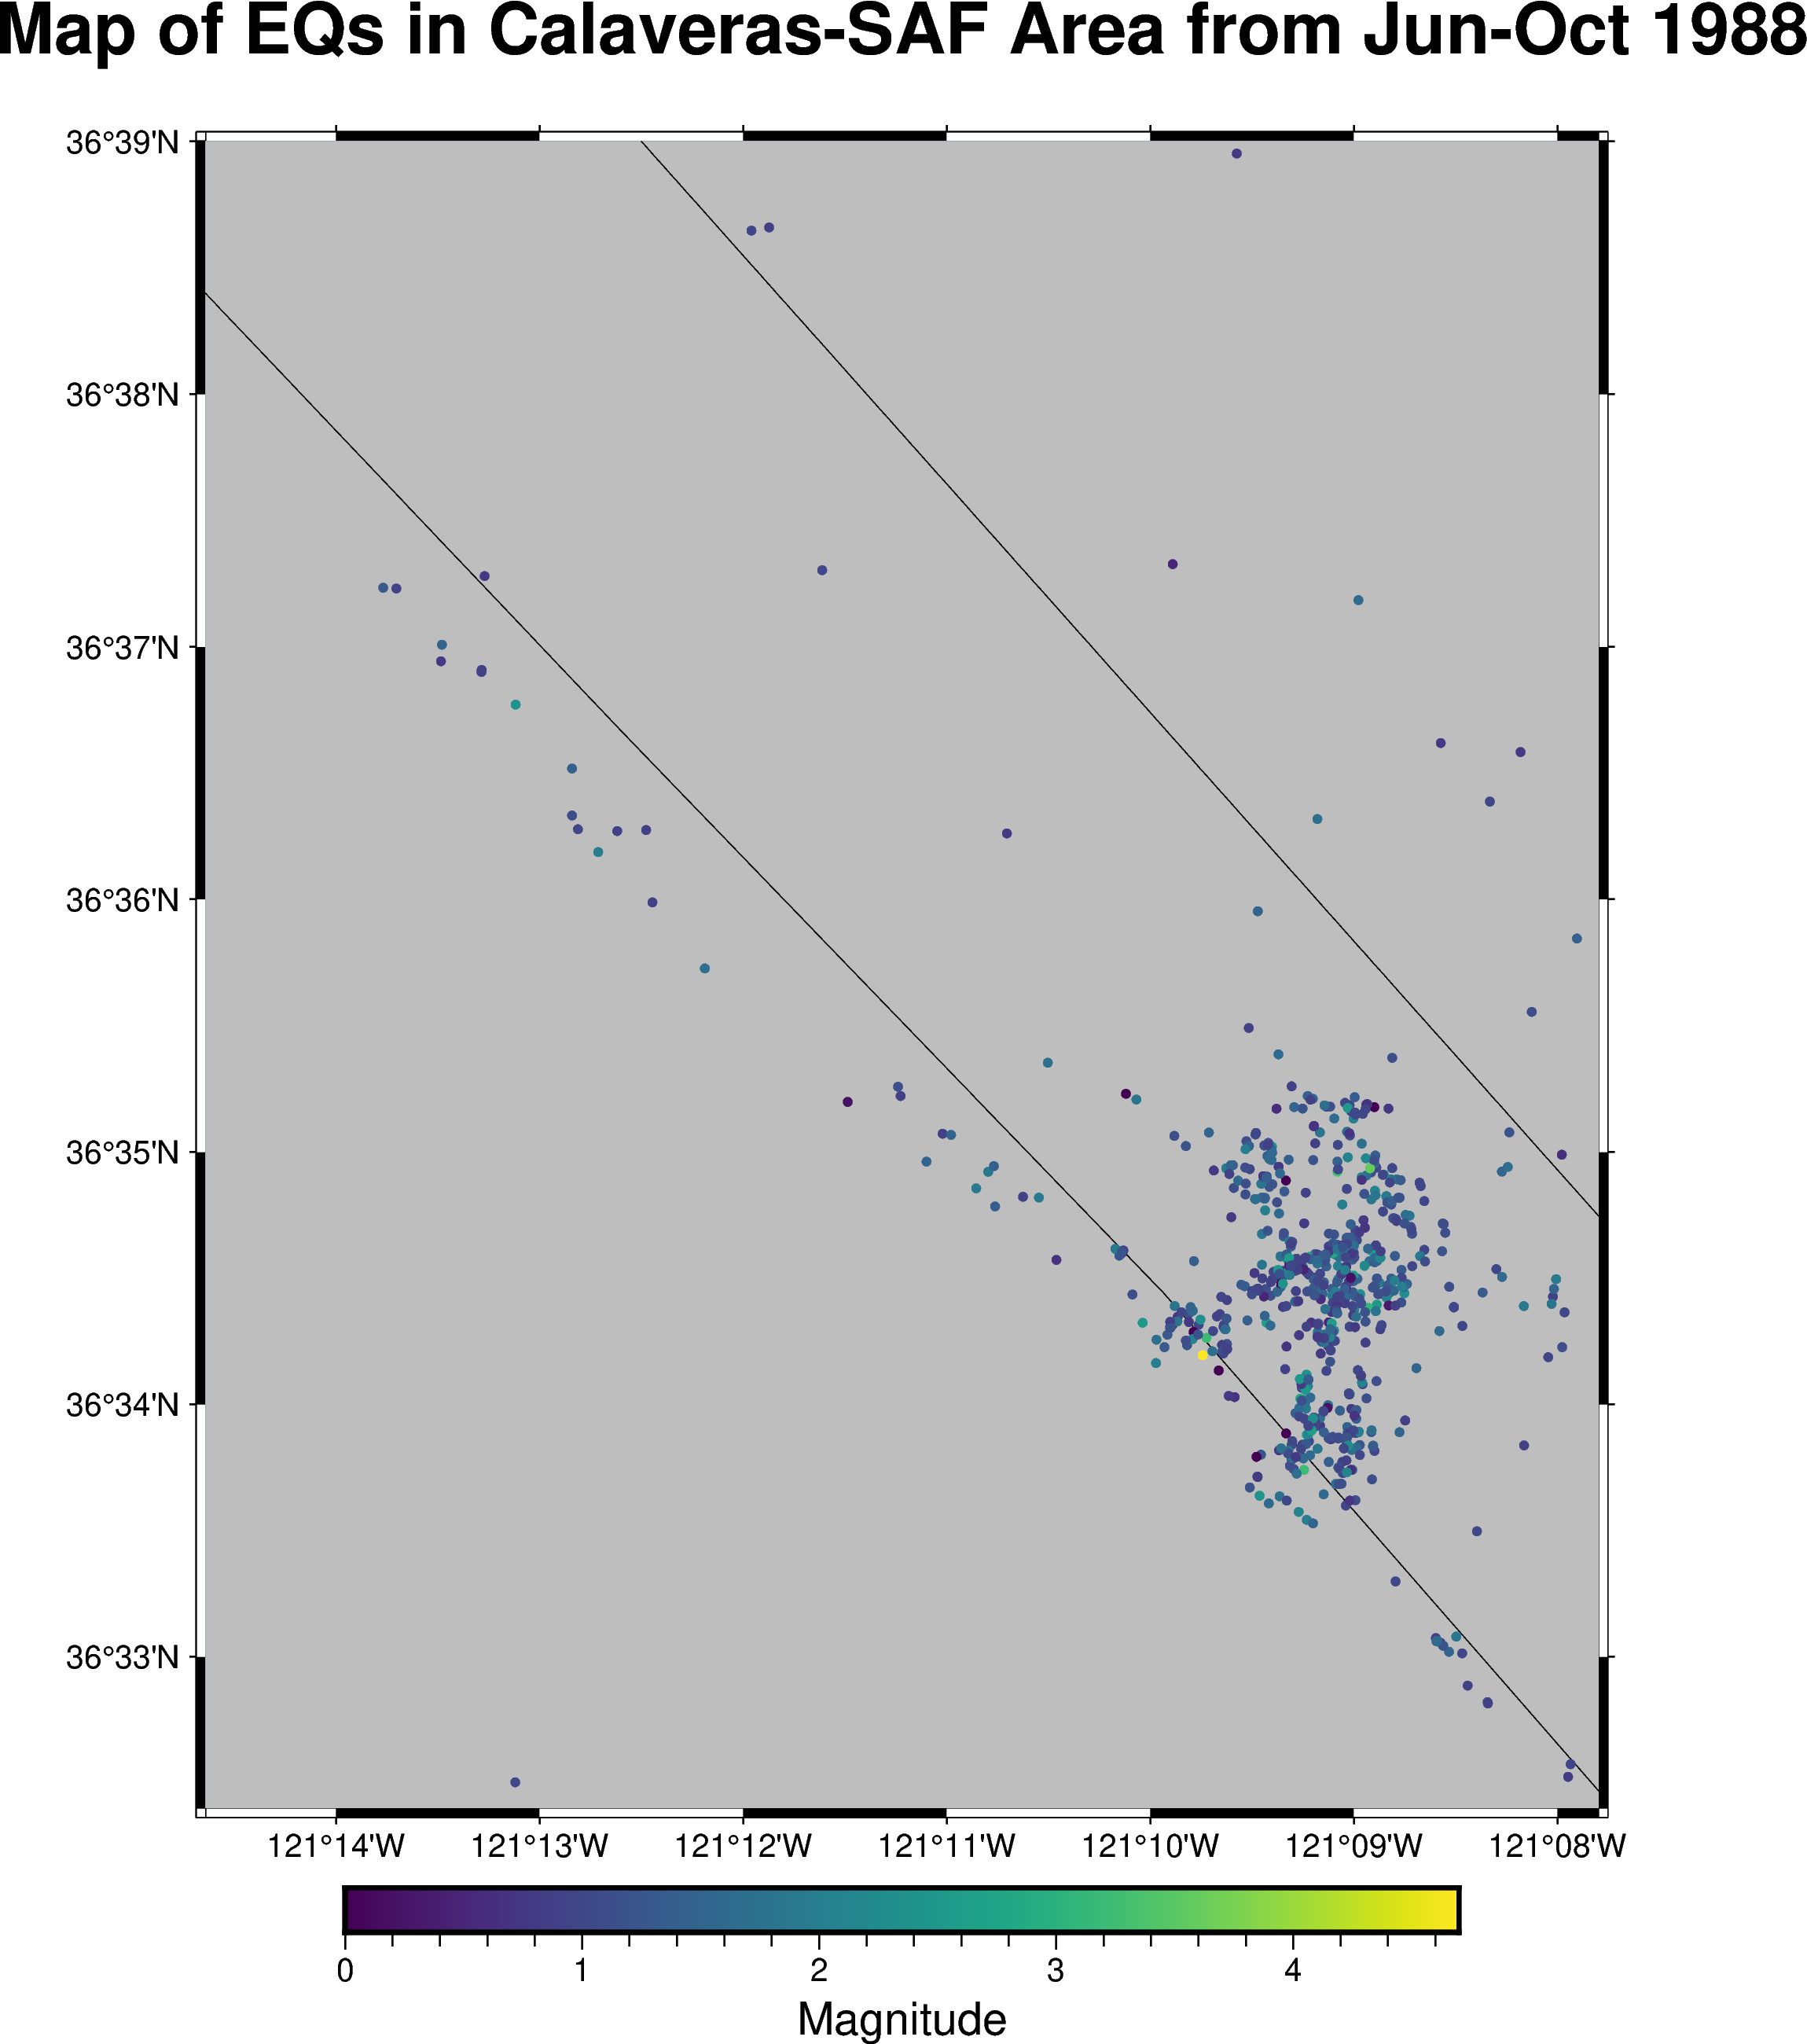

In [46]:
# Seismic Station Data
start = date(1988, 6, 1)
end = date(1988, 10, 31)
inv = client.get_stations(starttime=UTCDateTime(start), endtime=UTCDateTime(end), network=network, channel="?H?,?H?", 
                          minlatitude=CL_bounds[2]-0.1, maxlatitude=CL_bounds[3]+0.1, maxlongitude=CL_bounds[1]+0.2, 
                          minlongitude=CL_bounds[0]-0.2)
print(inv)

fig = pygmt.Figure()
fig.basemap(region=CL_bounds, projection="M15c", frame=["a", "+tMap of EQs in Calaveras-SAF Area from Jun-Oct 1988"])
fig.coast(land="gray", water="skyblue")
fig.plot(data=faults)
#gl = ax.gridlines(linestyle=":", draw_labels=True)
#plot sequences
pygmt.makecpt(cmap="viridis", series=[EQCL_spike.MAG.min(), EQCL_spike.MAG.max()])
fig.plot(x=EQCL_spike["LON"], y=EQCL_spike["LAT"], style="c0.1c", color =EQCL_spike["MAG"], cmap=True, no_clip=False )
fig.colorbar(frame='af+l"Magnitude"')
#plt.legend(*sc.legend_elements("sizes", num=5))


fig.show()
#probably aftershock sequence

In [47]:
#Mar-Jul 1995
CL_95 = rep_CL[rep_CL["YR"]==1995]
sel_marjul = np.logical_and(CL_95["MO"]>=3, CL_95["MO"]<=7)
repCL_95 = CL_95[sel_marjul]
repCL_95 = repCL_95.rename(columns={"level_0":"level_1"})
repCL_95 = repCL_95.reset_index()

C:\Users\awhip\Anaconda3\envs\ObsPy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


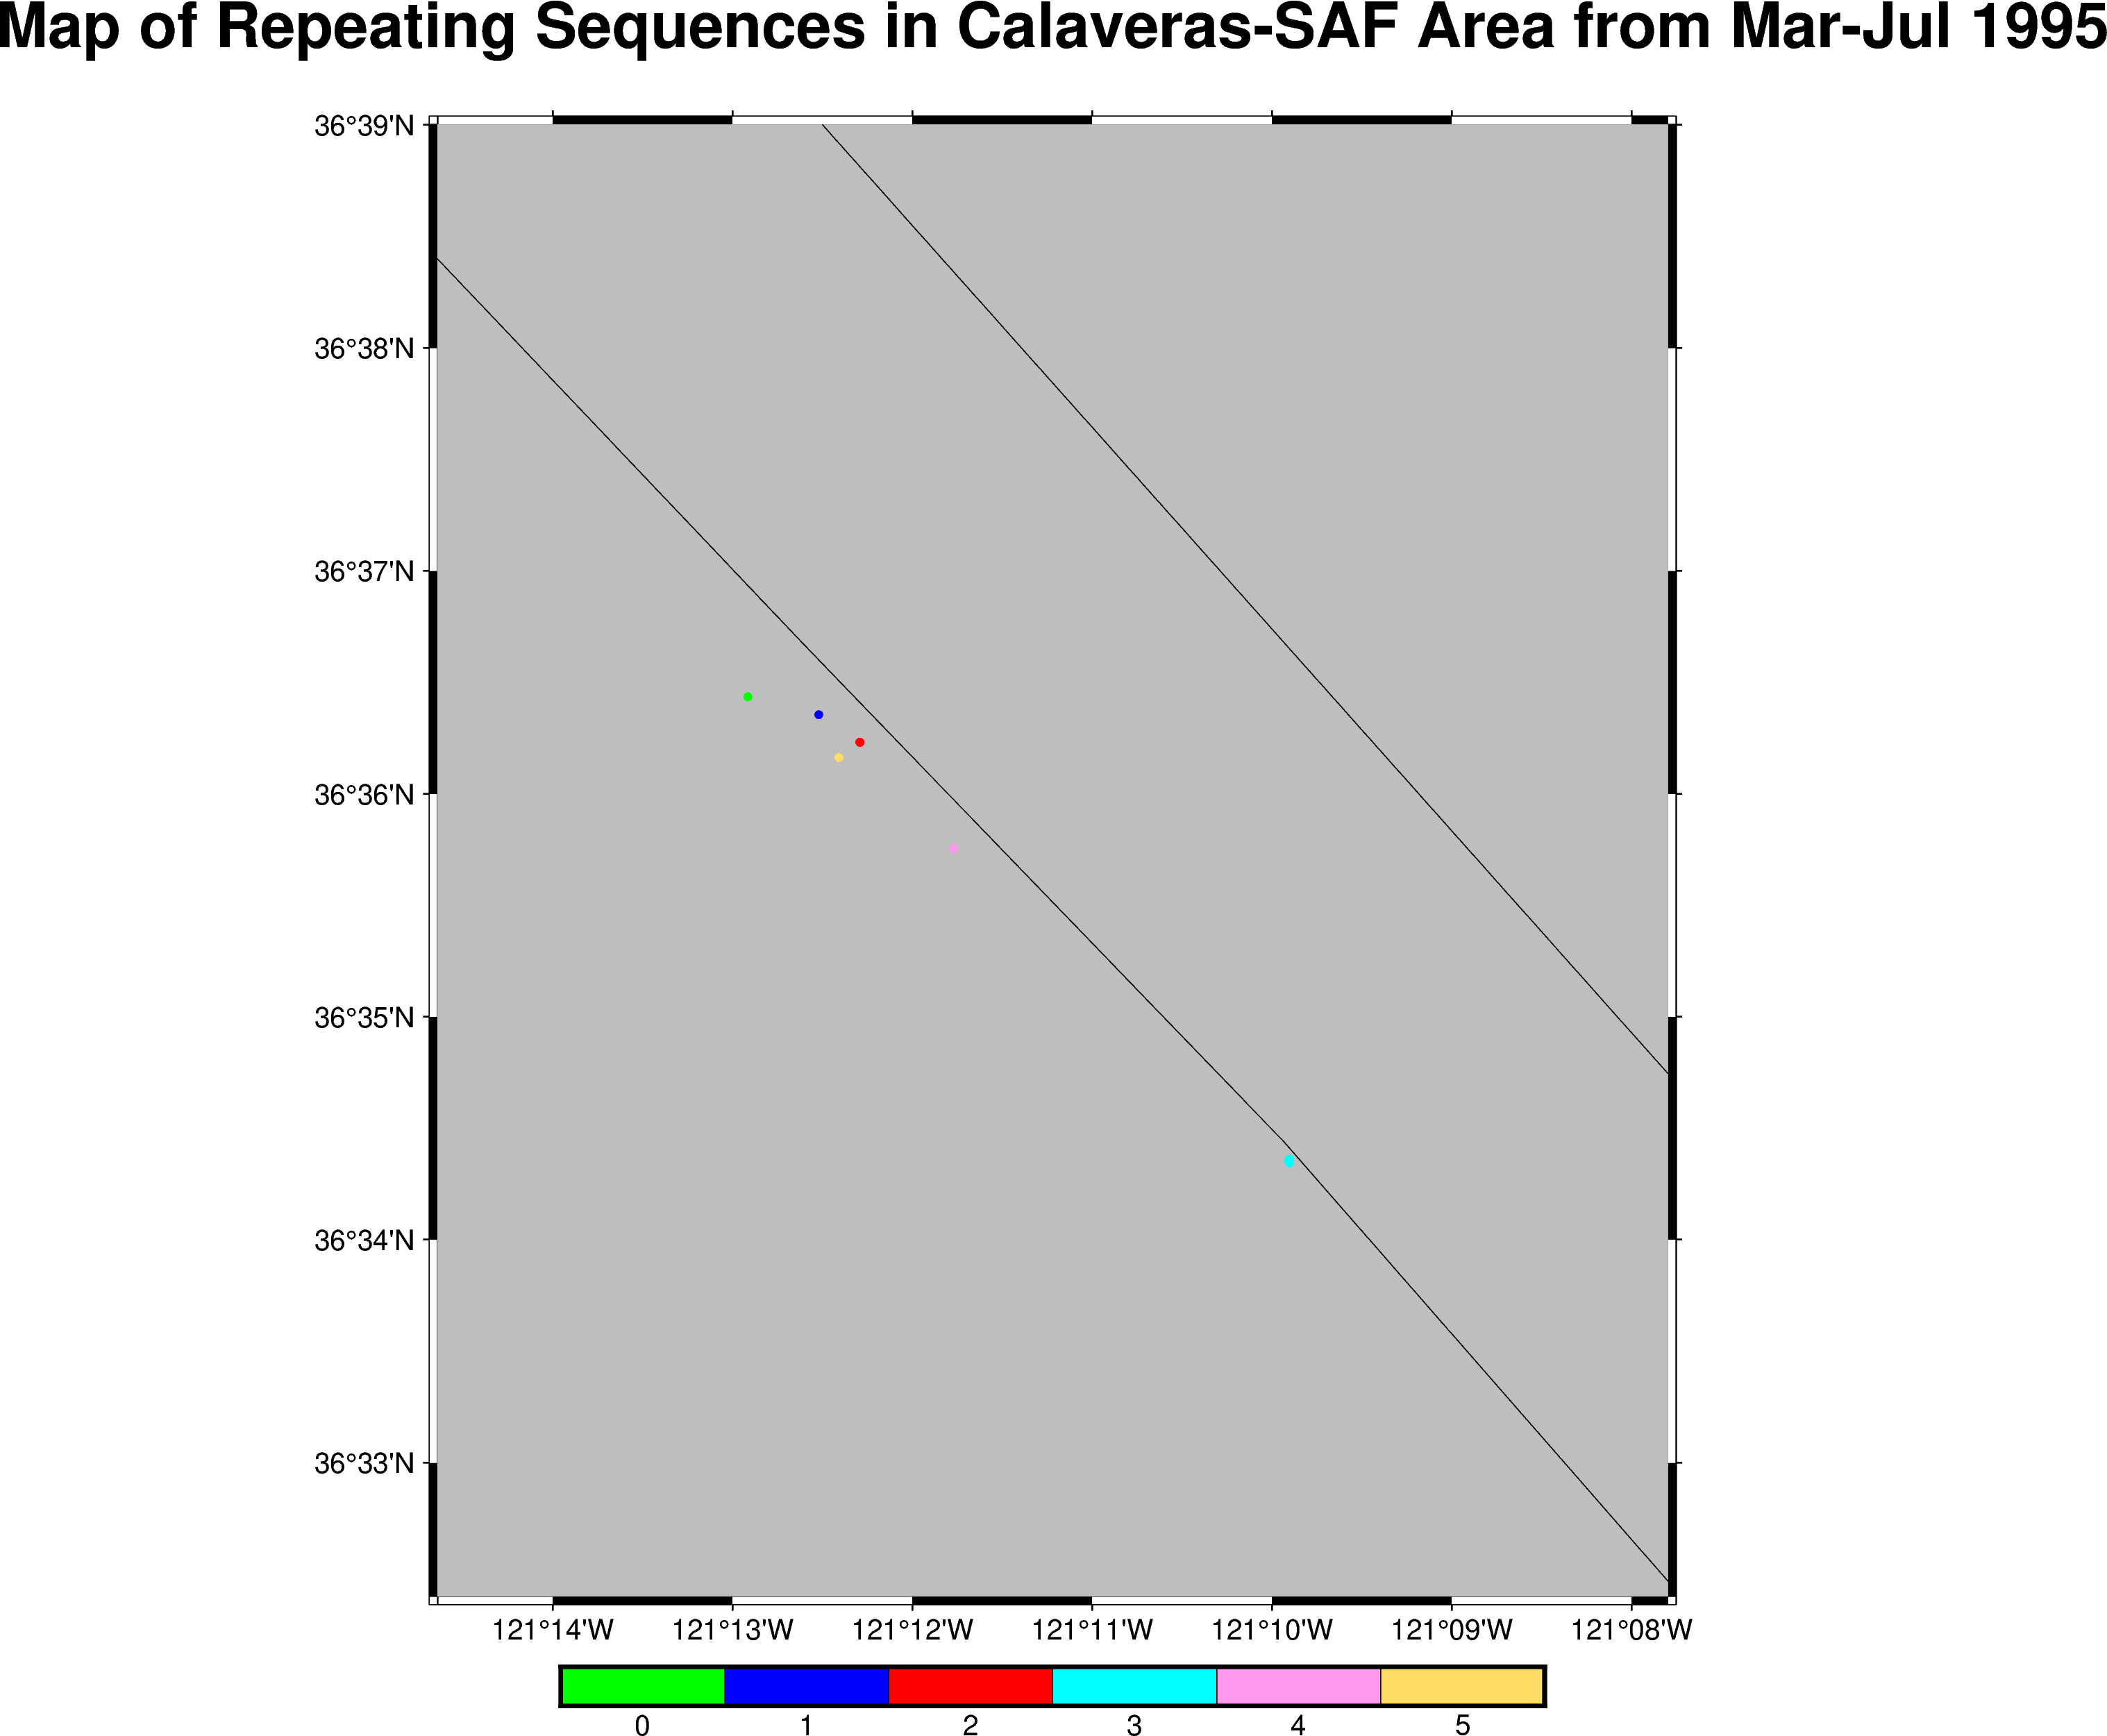

In [48]:
seqs = repCL_95.groupby("seqID")

repCL_95.seqID = repCL_95.seqID.astype(dtype="category")
cmodel = "+c"
for i in range(len(seqs.groups)):
    if i == len(seqs.groups)-1:
        cmodel= cmodel+"%i"%(i)
    else:
        cmodel= cmodel+"%i"%(i)+","
fig = pygmt.Figure()
fig.basemap(region=CL_bounds, projection="M15c", frame=["a", "+tMap of Repeating Sequences in Calaveras-SAF Area from Mar-Jul 1995"])
fig.coast(land="gray", water="skyblue")
pygmt.makecpt(cmap="categorical", series=(0, len(seqs.groups)-1, 1), color_model=cmodel)
fig.plot(data=faults)
#plot sequences
fig.plot(x=repCL_95["LON"], y=repCL_95["LAT"], style="c0.1c", color =repCL_95.seqID.cat.codes.astype(int), cmap = True, no_clip=True )
fig.colorbar()
fig.savefig(cwd+"/figures/Calaveras_95_seq.png")
fig.show()

In [49]:
#ncdc data
NCDC_95 = data_EQ[data_EQ["YEAR"]==1995]
sel_marjul = np.logical_and(NCDC_95["MONTH"]>=3, NCDC_95["MONTH"]<=7)
EQCL_95 = NCDC_95[sel_marjul]
EQCL_95 = EQCL_95.rename(columns={"level_0":"level_1"})
EQCL_95 = EQCL_95.reset_index()

C:\Users\awhip\Anaconda3\envs\ObsPy\lib\site-packages\geopandas\io\file.py:362: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  pd.Int64Index,


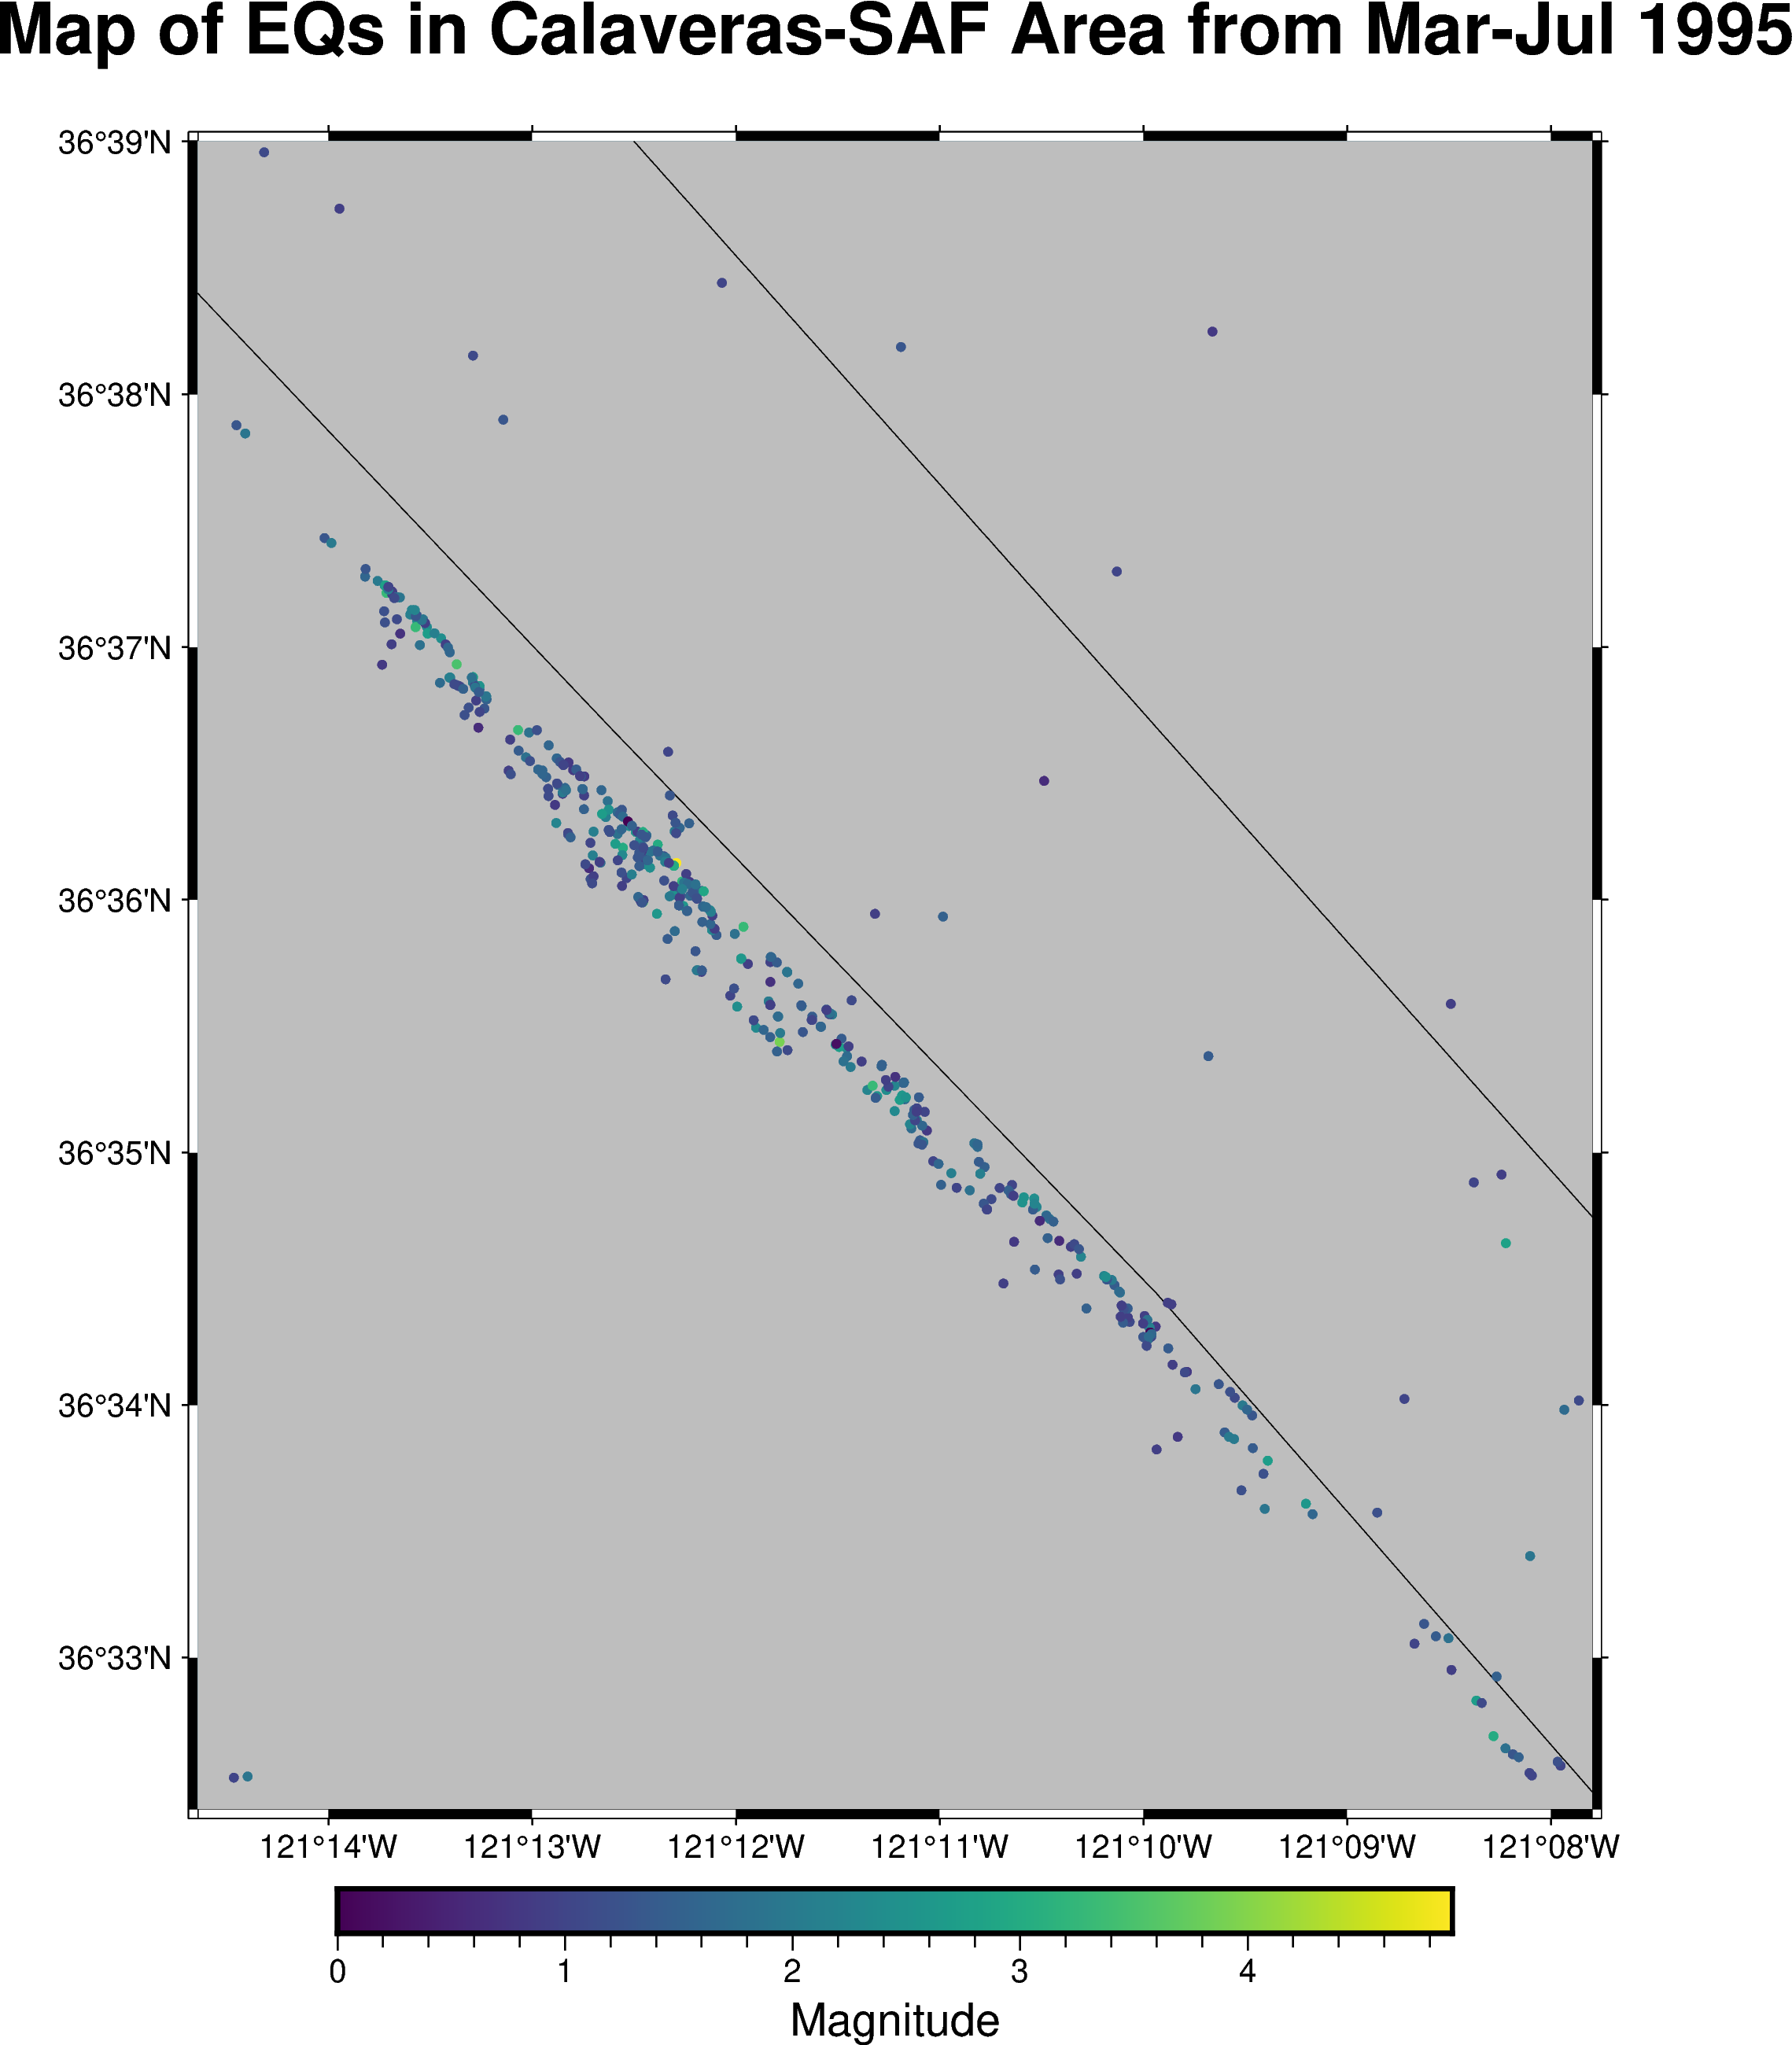

In [50]:
# Seismic Station Data
start = date(1995, 3, 1)
end = date(1995, 7, 31)
inv = client.get_stations(starttime=UTCDateTime(start), endtime=UTCDateTime(end), network=network, channel="?H?,?H?", 
                          minlatitude=CL_bounds[2], maxlatitude=CL_bounds[3], maxlongitude=CL_bounds[1], 
                          minlongitude=CL_bounds[0])
fig = pygmt.Figure()
fig.basemap(region=CL_bounds, projection="M15c", frame=["a", "+tMap of EQs in Calaveras-SAF Area from Mar-Jul 1995"])
fig.coast(land="gray", water="skyblue")
fig.plot(data=faults)
#gl = ax.gridlines(linestyle=":", draw_labels=True)
#plot sequences
pygmt.makecpt(cmap="viridis", series=[EQCL_95.MAG.min(), EQCL_95.MAG.max()])
fig.plot(x=EQCL_95["LON"], y=EQCL_95["LAT"], style="c0.1c", color =EQCL_95["MAG"], cmap=True, no_clip=False )
fig.colorbar(frame='af+l"Magnitude"')
#plt.legend(*sc.legend_elements("sizes", num=5))


fig.show()

# Spacio-Temporal Analysis Plots

In [24]:
sel_after88 = np.logical_and(rep_CL["YR"] == 1988, rep_CL["MO"] >=7)
sel_after88 = np.logical_and(sel_after88, rep_CL["MO"] <= 9)
sel_after88 = np.logical_and(sel_after88, rep_CL["DEP"] <=4)

sel_after95 = np.logical_and(rep_CL["YR"] == 1995, rep_CL["MO"] >=4)
sel_after95 = np.logical_and(sel_after95, rep_CL["MO"] <=5)
sel_after95 = np.logical_and(sel_after95, rep_CL["DEP"] >=4)
sel_after95 = np.logical_and(sel_after95, rep_CL["DEP"] <=7)

sel_after = np.logical_or(sel_after88, sel_after95)
sel_noafter = np.logical_not(sel_after)

In [25]:
rep_CL = rep_CL[sel_noafter]

In [26]:
t_win = t_win[sel_noafter]

In [27]:
fig, ax = plt.subplots(1, figsize = (12,12))
plt.scatter(t_win, (-1)*rep_CL["DEP"], c = rep_CL["LAT"], s = 3**rep_CL["NEV"]+10, edgecolors = "k", alpha = 0.6)
#plt.scatter(t_95,(-1)*m4_95["DEP"], marker='*')
cbar = plt.colorbar()
cbar.set_label("Latitude")
plt.xlabel("Time (Year)")
plt.ylabel("Depth (km)")
ax.set(title="Depth of Burst-Like Repeating Events around Melendy Ranch over Time")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['1984/01/01','2013/12/31']))
plt.savefig(cwd + "/Watson_Final_DepthTime.png", dpi=150)
plt.show()

In [28]:
fig, ax = plt.subplots(1, figsize = (12,12))
plt.scatter(rep_CL["LAT"], (-1)*rep_CL["DEP"], c = t_win/365 + 1970, s = 5**rep_CL["MAG"], edgecolors = "k", alpha = 0.6)
ax.set(title="Depth of Repeating Events around Melendy Ranch versus Latitude")
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
cbar = plt.colorbar()
cbar.set_label("Time (Year)")
plt.show()

In [29]:
fig, ax = plt.subplots(1, figsize = (12,12))
plt.scatter(rep_CL["LON"], (-1)*rep_CL["DEP"], c = t_win/365 + 1970, s = 5**rep_CL["MAG"], edgecolors = "k", alpha = 0.6)
ax.set(title="Depth of Repeating Events around Melendy Ranch versus Longitude")
plt.xlabel("Longitude")
plt.ylabel("Depth (km)")
cbar = plt.colorbar()
cbar.set_label("Time (Year)")
plt.show()

In [30]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

p = ax.scatter(rep_CL["LON"], rep_CL["LAT"], (-1)*rep_CL["DEP"], c = t_win/365 + 1970, s = 5**rep_CL["MAG"], edgecolors = "k", alpha = 0.6)
cbar = plt.colorbar(p, location = 'left')
cbar.set_label("Time (Year)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (km)")
plt.savefig(cwd + "/figures/spacial_temporal_MR.png", dpi = 300)
plt.show()

In [31]:
fig, ax = plt.subplots(1, figsize = (12,12))
plt.scatter(rep_CL["LAT"], (-1)*rep_CL["DEP"], c = t_win/365 + 1970, s = 3**rep_CL["NEV"]+10, edgecolors = "k", alpha = 0.6)
#plt.scatter(m4["LAT"],(-1)*m4["DEP"], marker='*')
ax.set(title="Depth of Repeating Events around Melendy Ranch versus Latitude")
plt.xlabel("Latitude")
plt.ylabel("Depth (km)")
cbar = plt.colorbar()
cbar.set_label("Time (Year)")
plt.show()

In [32]:
fig, ax = plt.subplots(1, figsize = (12,12))
n, bins, patches = plt.hist(t_win, bins = repbin_seq)
ax.set(title='Number Of Events vs. Time in (%.5f,%.5f,%.5f,%.5f)'%(CL_bounds[0], CL_bounds[1], CL_bounds[2], CL_bounds[3]))
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['1984/01/01','2013/12/31']))
file_map = cwd+'/figures/seqCL_noafter.png'
plt.savefig(file_map, dpi=150)
plt.show()

In [33]:
print(seq_CL)

    level_0  level_2  level_1  index  #  NEV     LATm      LONm    DEPm  \
0         0       55      112    848  #    3  36.6021 -121.2077   5.807   
1         3       95      178   1170  #    3  36.5769 -121.1530   3.293   
2        12      155      309   1663  #    4  36.5836 -121.1911   7.280   
3        21      184      375   1894  #    2  36.6046 -121.2188   7.015   
4        25      208      403   2021  #    2  36.5944 -121.1499   8.895   
..      ...      ...      ...    ... ..  ...      ...       ...     ...   
74      369     2290     6838  32329  #    2  36.5722 -121.2142  12.115   
75      371     2303     6911  32559  #    2  36.5688 -121.1383   8.506   
76      372     2319     7026  32909  #    3  36.6155 -121.2235   5.796   
77      381     2414     7533  34824  #    3  36.5488 -121.1350   2.289   
78      389     2427     7710  35378  #    2  36.6273 -121.2344   5.139   

    DMAGm  DMAGs     RCm     RCs  RCcv   RCm1  RCs1  RCcv1   CCm  \
0    1.07   0.16  1751.0  2469.

In [34]:
fig, ax = plt.subplots(1, figsize = (12,12))
plt.scatter(t_nb, (-1)*nb_CL["DEP"], c = nb_CL["LAT"], s = nb_CL["NEV"]**2+10, edgecolors = "k", alpha = 0.6)
#plt.scatter(t_95,(-1)*m4_95["DEP"], marker='*')
cbar = plt.colorbar()
cbar.set_label("Latitude")
plt.xlabel("Time (Year)")
plt.ylabel("Depth (km)")
ax.set(title="Depth of Characteristic Repeating Events around Melendy Ranch over Time")
ax.xaxis.set_major_locator(mdates.YearLocator())
ax.xaxis.set_major_formatter(mdates.DateFormatter('%y'))
plt.xlim(mdates.datestr2num(['1984/01/01','2013/12/31']))
plt.savefig(cwd + "/Watson_Final_DepthTime_char.png", dpi=150)
plt.show()

In [35]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

p = ax.scatter(nb_CL["LON"], nb_CL["LAT"], (-1)*nb_CL["DEP"], c = t_nb/365 + 1970, s = 5**nb_CL["MAG"], edgecolors = "k", alpha = 0.6)
cbar = plt.colorbar(p, location = 'left')
cbar.set_label("Time (Year)")
ax.set_xlabel("Longitude")
ax.set_ylabel("Latitude")
ax.set_zlabel("Depth (km)")
plt.savefig(cwd + "/figures/spacial_temporal_MR_char.png", dpi = 300)
plt.show()

In [36]:
#print(EQCL_95)

NameError: name 'EQCL_95' is not defined